In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm, inv
from tqdm import tqdm

In [9]:
# Take minimum error for all positive and negative x
def min_error(x_hat, x_star):
    errors = []
    for x in x_hat:
            error_positive = np.linalg.norm(x_star - x)
            error_negative = np.linalg.norm(-x_star - x)
            errors.append(min(error_positive, error_negative))
    return errors

def plot_data(x):
    plt.imshow(x, cmap='gray')
    plt.title("X")
    plt.axis('off')
    plt.show()

In [3]:
def bwgd(y, A, niter=30, init="spec2"):
    d, n = A.shape
    x = np.zeros((niter, d))

    # Covariance matrix transform
    C = A @ A.T / n
    C_sqrt = sqrtm(C)
    C_inv = np.real(inv(C_sqrt))
    A_tilde = C_inv @ A

    # Initialization
    if init=="spec2":
        lambda_sq = (1 / n) * np.sum(y)
        lambda_val = np.sqrt(lambda_sq)
        Y = (1 / n) * (A_tilde @ np.diag((1/2 - np.exp(-y / lambda_sq)) ) @ A_tilde.T)
        eigenvals, eigenvects = np.linalg.eigh(Y)
        index = np.argmax(eigenvals)
        eigenvect = eigenvects[:, index]
        x_tilde = lambda_val * (eigenvect/ np.linalg.norm(eigenvect)) 
        x[0] = C_inv @ x_tilde
    
    elif init=="spec1":
        Y = (1 / n) * (A_tilde @ np.diag(y) @ A_tilde.T)
        eigenvals, eigenvects = np.linalg.eigh(Y)
        index = np.argmax(eigenvals)  
        x_tilde = np.sqrt(eigenvals[index] / 3) * eigenvects[:, index]
        x[0] = C_inv @ x_tilde
   
    elif init=="rand":
         x_tilde= np.random.randn(d)
         x[0] = C_inv @ x_tilde
           
    for iter in range(1, niter):
        hessian = (A_tilde @ A_tilde.T) / n
        
        # Gradient
        At_x = A_tilde.T @ x_tilde  
        gradient = hessian @ x_tilde - A_tilde @ (np.sqrt(y) * At_x / (np.abs(At_x)*n))
        x_tilde -= np.linalg.solve(hessian, gradient)

        x[iter] = C_inv @ x_tilde

        # Check for convergence
        if np.linalg.norm(x[iter] - x[iter - 1]) < 1e-10:
            return x[:iter], iter

    return x, iter

In [4]:
def load_v73_mat(filepath, variable_name):
    with h5py.File(filepath, 'r') as f:
        data = f[variable_name][()]  # Get raw HDF5 data
        data = np.array(data).T      # Transpose to match MATLAB's column-major order
    return data

In [11]:
# Load Data
A = load_v73_mat('AmpSLM_16x16/A_prVAMP.mat', 'A')
XH = load_v73_mat('AmpSLM_16x16/XH_test.mat', 'XH_test')
YH = load_v73_mat('AmpSLM_16x16/YH_squared_test.mat', 'YH_squared_test')

In [6]:
# Load Data
A = load_v73_mat('AmpSLM_16x16/A_GS.mat', 'A')
XH = load_v73_mat('AmpSLM_16x16/XH_test.mat', 'XH_test')
YH = load_v73_mat('AmpSLM_16x16/YH_squared_test.mat', 'YH_squared_test')

In [14]:
# A is structured: dtype [('real', '<f4'), ('imag', '<f4')]
A_complex = A['real'] + 1j * A['imag']

# Reduce m (number of measurements) from 6553
max = 3500
A_small = A_complex[:max, :]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

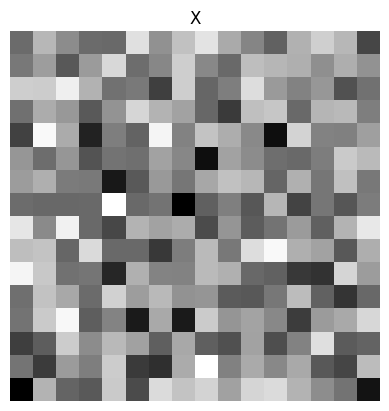

 20%|████████████████▊                                                                   | 1/5 [00:01<00:06,  1.62s/it]

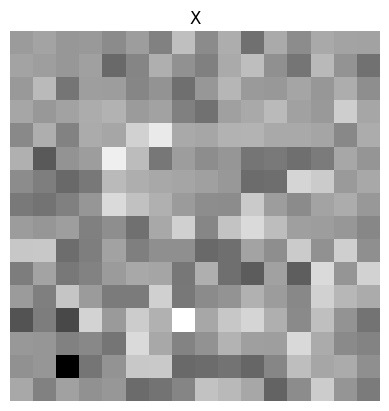

 40%|█████████████████████████████████▌                                                  | 2/5 [00:03<00:05,  1.71s/it]

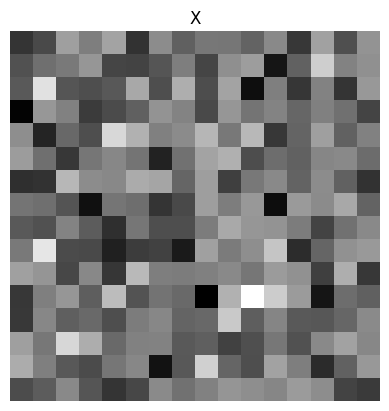

 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:05<00:03,  1.75s/it]

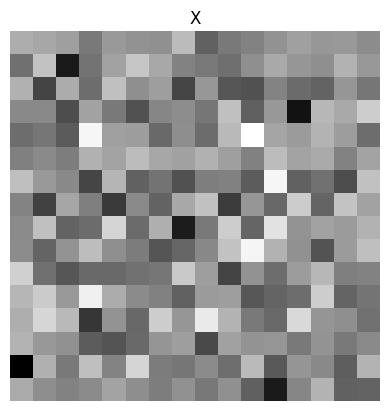

 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:08<00:02,  2.26s/it]

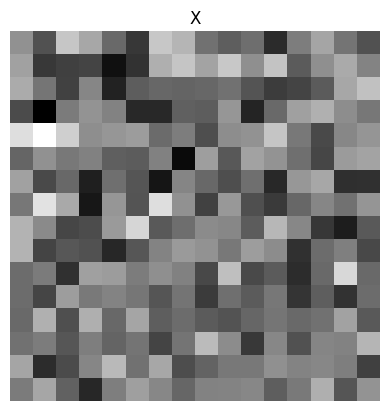

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.94s/it]


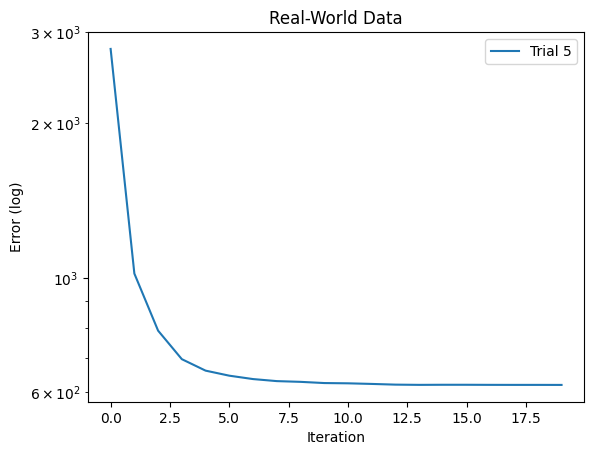

In [13]:
d = A.shape[1]
m = A.shape[0]

for j in tqdm(range(5)):
    x = XH[j, :]/255
    y = YH[j, :].flatten() 
    y = y[:max]
    #y = np.square(A @ x) 

    
    # Run your algorithm
    x_hat, iters = bwgd(y, A_small.T, init="spec2")
    
    # Compute alignment-invariant error
    error = []
    for xi in x_hat:
        error.append(np.linalg.norm(np.square(np.absolute(A_small@xi))-y))

    plot_data(x_hat[-1].reshape(16, 16))
    
    # Plot error per iteration
    plt.plot(error, label=f"Trial {j+1}")

plt.xlabel("Iteration")
plt.ylabel("Error (log)")
plt.yscale('log')  
plt.title("Real-World Data")
plt.legend()
plt.show()

In [180]:
x.shape

(256,)

In [190]:
#np.linalg.norm(np.square(A @ x) -y)
x = XH[j, :]/500
y = YH[j, :].flatten() 

In [191]:
np.square(np.absolute(A_complex @ x))

array([ 2.30006283,  2.02572522,  1.93236825, ..., 10.84266348,
       13.6306875 , 13.60159879])

In [175]:
y

array([ 6,  6,  5, ..., 23, 30, 28], dtype=uint8)

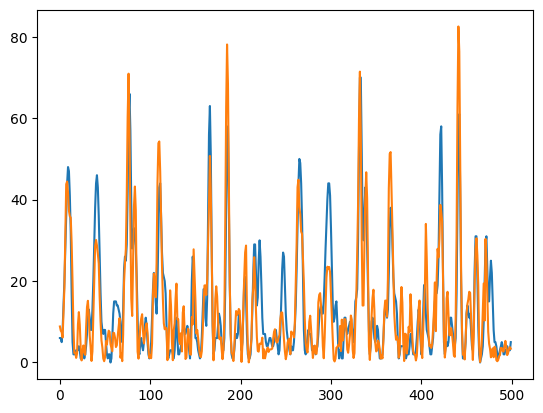

In [177]:
plt.plot(y[:500])
plt.plot(np.square(np.absolute(A_complex @ x))[:500])
plt.show()

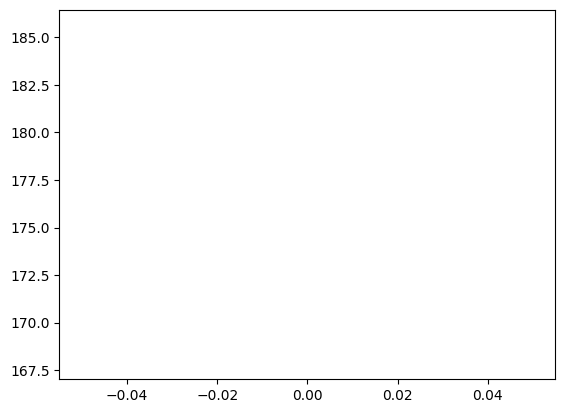

In [186]:
plt.plot(np.linalg.norm(y[:500]-np.square(np.absolute(A_complex @ x))[:500]))

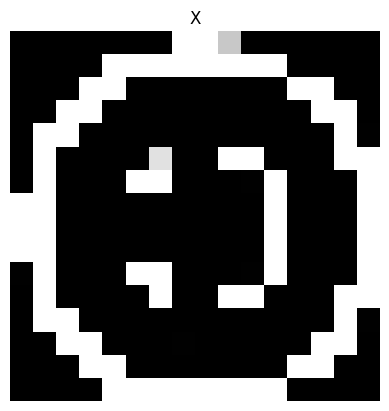

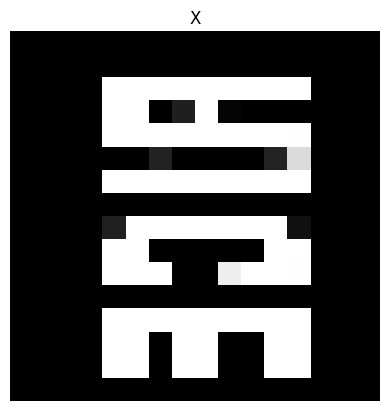

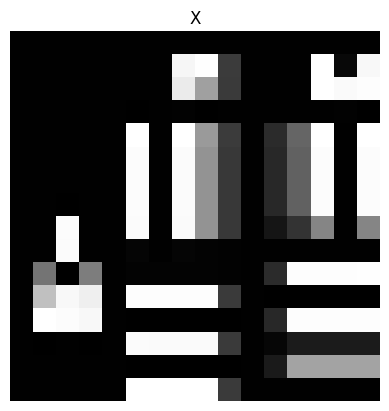

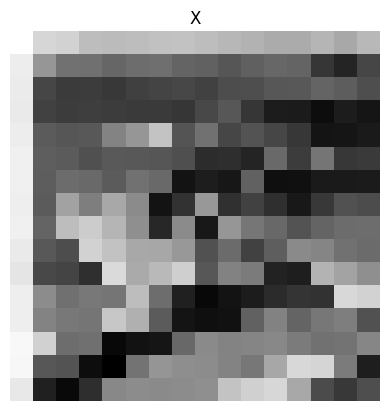

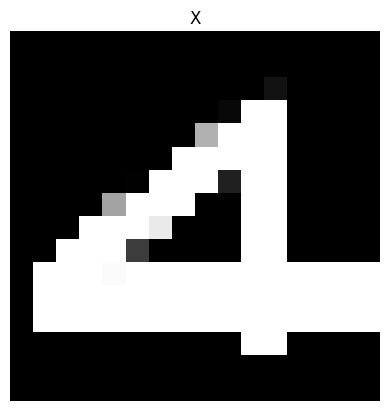

In [115]:
# Pick a test index
for i in range(5):
    x = XH[i, :]
    plot_data(x.reshape(16, 16))